In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import KAN
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

In [2]:
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

In [11]:
import os
os.environ["NCCL_DEBUG"] = "INFO"
os.environ["NCCL_BLOCKING_WAIT"] = "1"
os.environ["NCCL_P2P_DISABLE"] = "1"
os.environ["NCCL_IB_DISABLE"] = "1"

os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [12]:
fcst = NeuralForecast(
    models=[
            KAN(h=12,
                input_size=24,
                loss = DistributionLoss(distribution="Normal"),
                max_steps=100,
                scaler_type='standard',
                futr_exog_list=['y_[lag12]'],
                hist_exog_list=None,
                stat_exog_list=['airline1'],
                ),     
    ],
    freq='M'
)

Seed set to 1


In [13]:
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic)
forecasts = fcst.predict(futr_df=Y_test_df)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2025-01-24 15:13:05.716525: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 15:13:05.730748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737702785.749019  118654 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
/home/brain/anaconda3/envs/alignment/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/brain/anaconda3/envs/alignment/lib/python3.10/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

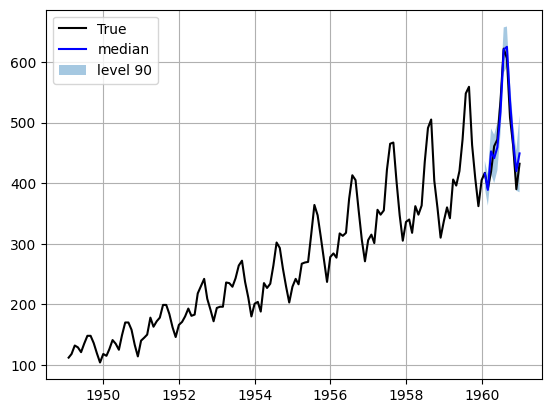

In [14]:
# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['KAN-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:], 
                 y1=plot_df['KAN-lo-90'][-12:].values,
                 y2=plot_df['KAN-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.legend()
plt.grid()


## KAN Regression

cuda


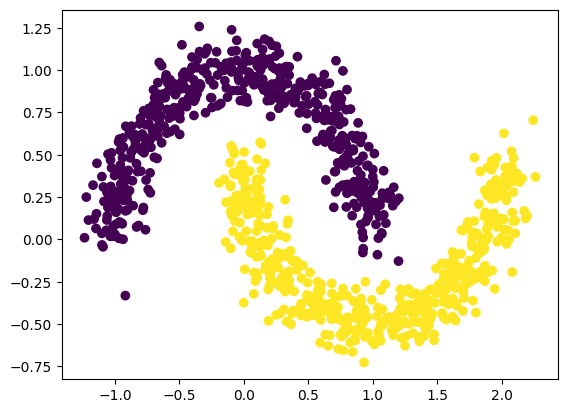

In [15]:
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dtype = torch.get_default_dtype()
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label[:,None]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label[:,None]).type(dtype).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:,0].cpu().detach().numpy())

In [22]:
dataset["train_input"].shape

torch.Size([1000, 2])

In [16]:
model = KAN(width=[2,1], grid=3, k=3, device=device)

def train_acc():
    return torch.mean((torch.round(model(dataset['train_input'])[:,0]) == dataset['train_label'][:,0]).type(dtype))

def test_acc():
    return torch.mean((torch.round(model(dataset['test_input'])[:,0]) == dataset['test_label'][:,0]).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc));
results['train_acc'][-1], results['test_acc'][-1]

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.56e-01 | test_loss: 1.56e-01 | reg: 3.93e+00 | : 100%|█| 20/20 [00:01<00:00, 18.86it

saving model version 0.1


(0.999000072479248, 0.9980000257492065)

In [24]:
results.keys()

dict_keys(['train_loss', 'test_loss', 'reg', 'train_acc', 'test_acc'])

In [18]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
# ex_round(formula, 4)

fixing (0,0,0) with sin, r2=0.9681435823440552, c=2
fixing (0,1,0) with x, r2=0.9766705632209778, c=1
saving model version 0.2


In [25]:
formula

-0.858788314512566*x_2 - 0.382751107215881*sin(3.09135985374451*x_1 + 4.74376010894775) + 0.706984093326383

In [19]:
# how accurate is this formula?
def acc(formula, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        correct += np.round(np.array(formula.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)) == y[i,0]
    return correct/batch

print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.9980, device='cuda:0')
test acc of the formula: tensor(0.9970, device='cuda:0')


## KAN Classification

Documentation: https://kindxiaoming.github.io/pykan/index.html

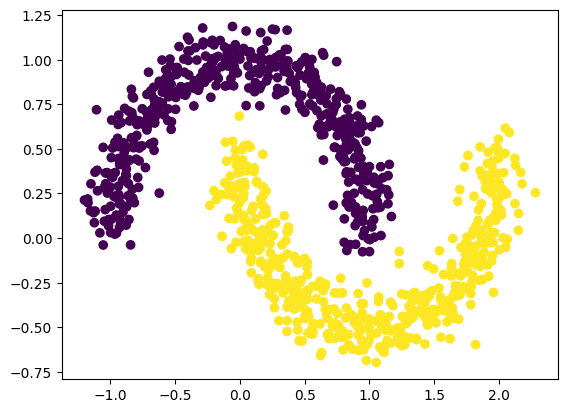

In [26]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())

In [27]:
model = KAN(width=[2,2], grid=3, k=3, seed=2024, device=device)

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

results = model.fit(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), loss_fn=torch.nn.CrossEntropyLoss());

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 0.00e+00 | test_loss: 1.65e-01 | reg: 4.17e+02 | : 100%|█| 20/20 [00:01<00:00, 12.93it

saving model version 0.1


In [28]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.519755482673645, c=1
fixing (0,0,1) with x, r2=0.40847665071487427, c=1
fixing (0,1,0) with x, r2=0.9347389340400696, c=1
fixing (0,1,1) with x, r2=0.9360458850860596, c=1
saving model version 0.2


In [30]:
formula1, formula2 = model.symbolic_formula()[0]
ex_round(formula1, 4)

-69.1591*x_1 + 158.1217*x_2 - 26.2463

In [31]:
# how accurate is this formula?
def acc(formula1, formula2, X, y):
    batch = X.shape[0]
    correct = 0
    for i in range(batch):
        logit1 = np.array(formula1.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        logit2 = np.array(formula2.subs('x_1', X[i,0]).subs('x_2', X[i,1])).astype(np.float64)
        correct += (logit2 > logit1) == y[i]
    return correct/batch

print('train acc of the formula:', acc(formula1, formula2, dataset['train_input'], dataset['train_label']))
print('test acc of the formula:', acc(formula1, formula2, dataset['test_input'], dataset['test_label']))

train acc of the formula: tensor(0.8720, device='cuda:0')
test acc of the formula: tensor(0.8670, device='cuda:0')
